Model loaded successfully from p_to_p_3.keras


Model: "pen_to_pixel_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,375,356 (100.61 MB)

 Trainable params: 8,791,486 (33.54 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 17,582,974 (67.07 MB)

Testing on images in /home/mudda/by_merge...


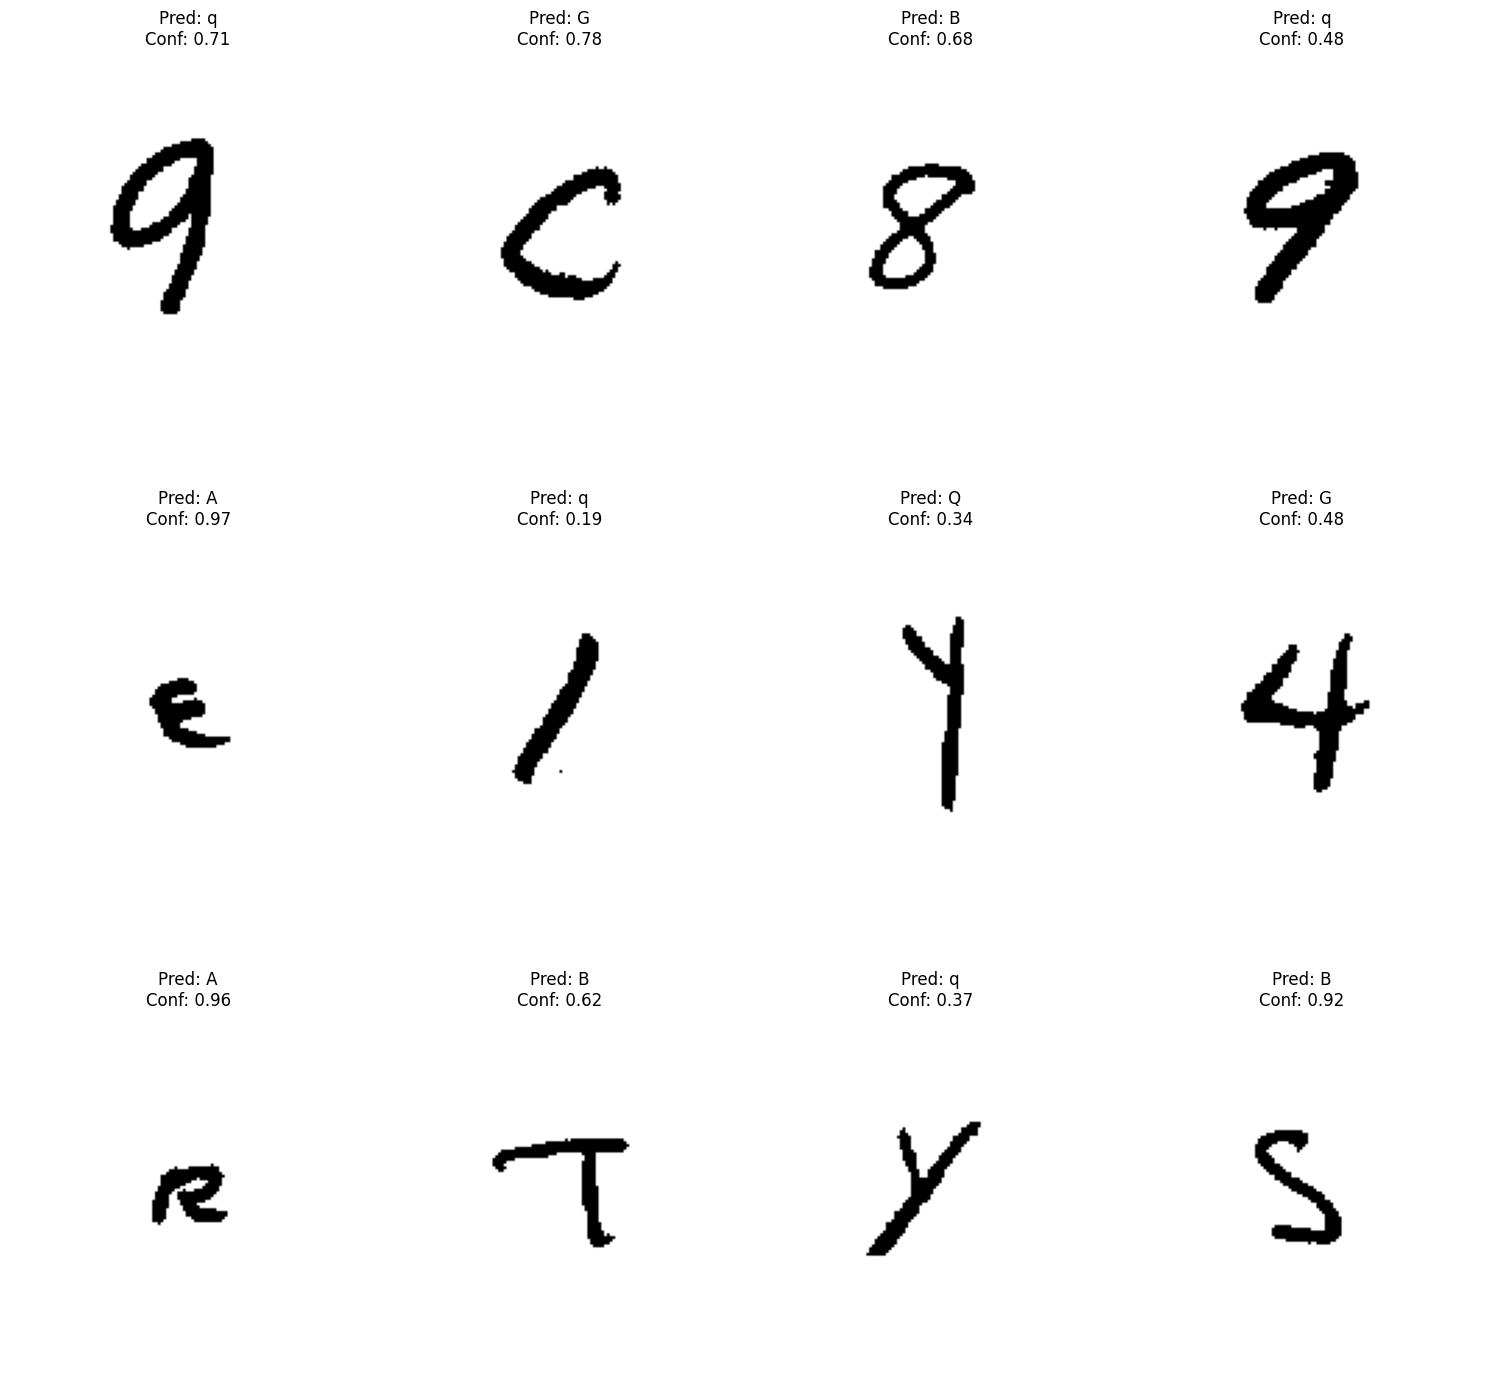

Test dataset not specified or not found


In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def load_sd19_model(model_path):
    """Load the trained model"""
    try:
        model = keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def load_and_preprocess_image(image_path, img_size=(128, 128)):
    """Load and preprocess a single image"""
    try:
        # Load image in grayscale
        img = Image.open(image_path).convert('L')
        # Resize to match model's expected input
        img = img.resize(img_size)
        # Convert to numpy array
        img_array = np.array(img)
        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0
        # Add batch and channel dimensions
        img_array = np.expand_dims(img_array, axis=-1)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def predict_on_image(model, image_path, class_names):
    """Make prediction on a single image"""
    # Preprocess the image
    processed_image = load_and_preprocess_image(image_path)
    if processed_image is None:
        return None, None
    
    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    return predicted_class, confidence

def test_on_directory(model, test_dir, class_names, num_samples=10):
    """Test the model on a directory of images"""
    # Get all image paths
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp']
    image_paths = []
    
    for root, _, files in os.walk(test_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))
    
    if not image_paths:
        print(f"No images found in {test_dir}")
        return
    
    # Select random samples if there are more than num_samples
    if len(image_paths) > num_samples:
        selected_paths = np.random.choice(image_paths, num_samples, replace=False)
    else:
        selected_paths = image_paths
    
    # Create a figure for plotting
    num_cols = 4
    num_rows = (len(selected_paths) + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 5 * num_rows))
    
    # Process each image
    for i, image_path in enumerate(selected_paths):
        # Make prediction
        predicted_class, confidence = predict_on_image(model, image_path, class_names)
        if predicted_class is None:
            continue
        
        # Check if predicted_class is within valid range
        if predicted_class >= len(class_names):
            print(f"Warning: Predicted class {predicted_class} is out of range for class names list")
            class_label = f"Class {predicted_class}"
        else:
            class_label = class_names[predicted_class]
        
        # Load and preprocess image for display
        img = Image.open(image_path).convert('L')
        img = img.resize((128, 128))
        img_array = np.array(img)
        
        # Plot the image
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img_array, cmap='gray')
        plt.title(f'Pred: {class_label}\nConf: {confidence:.2f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_data_dir, class_names, img_size=(128, 128), batch_size=32):
    """Evaluate model on a test dataset"""
    # Create a test data generator
    test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=img_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Check if the number of classes matches
    num_classes_in_data = len(test_generator.class_indices)
    if num_classes_in_data != len(class_names):
        print(f"Warning: Dataset has {num_classes_in_data} classes but model expects {len(class_names)} classes")
    
    # Evaluate the model
    evaluation = model.evaluate(test_generator, verbose=1)
    
    print(f"Test Loss: {evaluation[0]:.4f}")
    print(f"Test Accuracy: {evaluation[1]:.4f}")
    
    # Generate predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get true classes
    true_classes = test_generator.classes
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes))

def main():
    # EMNIST class names (62 classes) - since your model has 62 outputs
    emnist_class_names = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
        'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
        'U', 'V', 'W', 'X', 'Y', 'Z',
        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
        'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
        'u', 'v', 'w', 'x', 'y', 'z'
    ]
    
    # Hardcode your paths here
    model_path = "p_to_p_3.keras"  # Your model file
    test_dir = "/home/mudda/by_merge"  # Your test directory
    test_dataset = None  # Set to None since you don't have organized dataset
    
    # Load the model
    model = load_sd19_model(model_path)
    if model is None:
        return
    
    # Print model summary
    model.summary()
    
    # Test on individual images if directory is provided and exists
    if test_dir and os.path.exists(test_dir):
        print(f"Testing on images in {test_dir}...")
        test_on_directory(model, test_dir, emnist_class_names, num_samples=12)
    else:
        print(f"Test directory {test_dir} not found or not specified")
    
    # Evaluate on organized dataset if provided and exists
    if test_dataset and os.path.exists(test_dataset):
        print(f"Evaluating on dataset in {test_dataset}...")
        evaluate_model(model, test_dataset, emnist_class_names, img_size=(128, 128))
    else:
        print(f"Test dataset not specified or not found")

if __name__ == "__main__":
    main()

📋 Class Labels Overview:
   Digits (0-9): Classes 0-9
   Uppercase (A-Z): Classes 10-35
   Lowercase (a-z): Classes 36-61
   Total classes: 62
Model loaded successfully from p_to_p_3.keras



Model: "pen_to_pixel_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,375,356 (100.61 MB)

 Trainable params: 8,791,486 (33.54 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 17,582,974 (67.07 MB)


🔍 Testing on images in /home/mudda/by_merge...
Found 814255 images in the directory


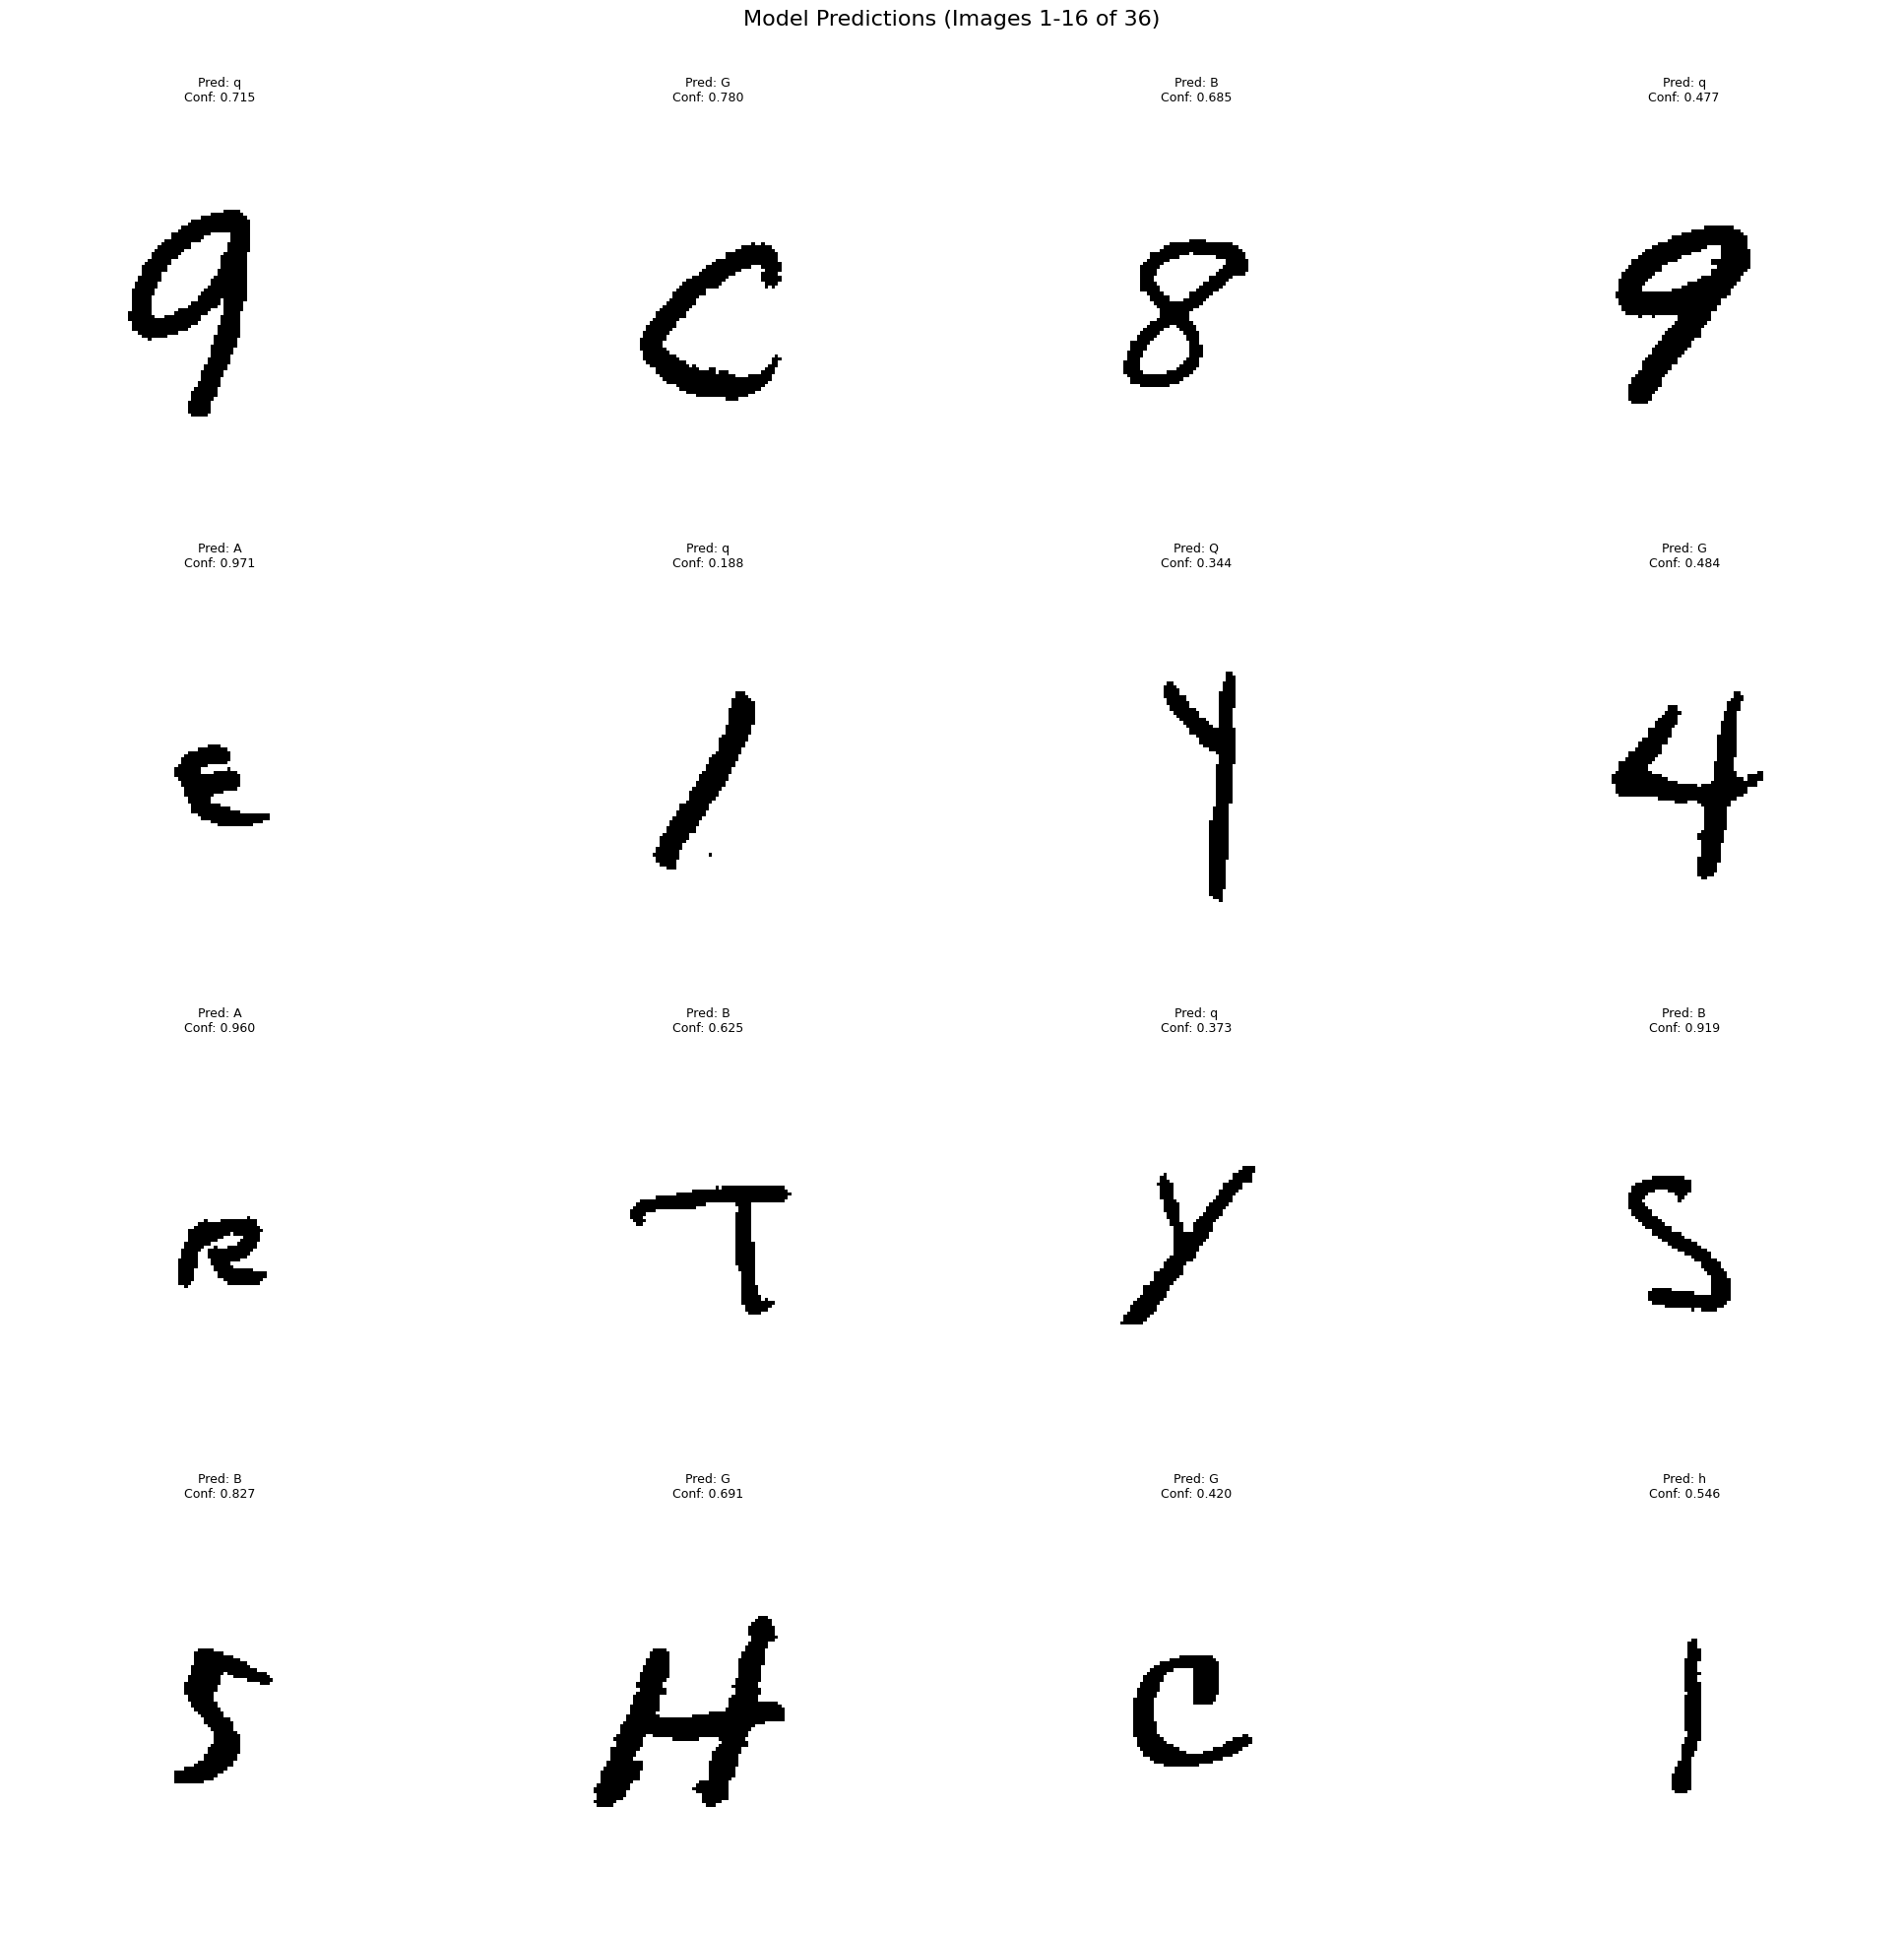

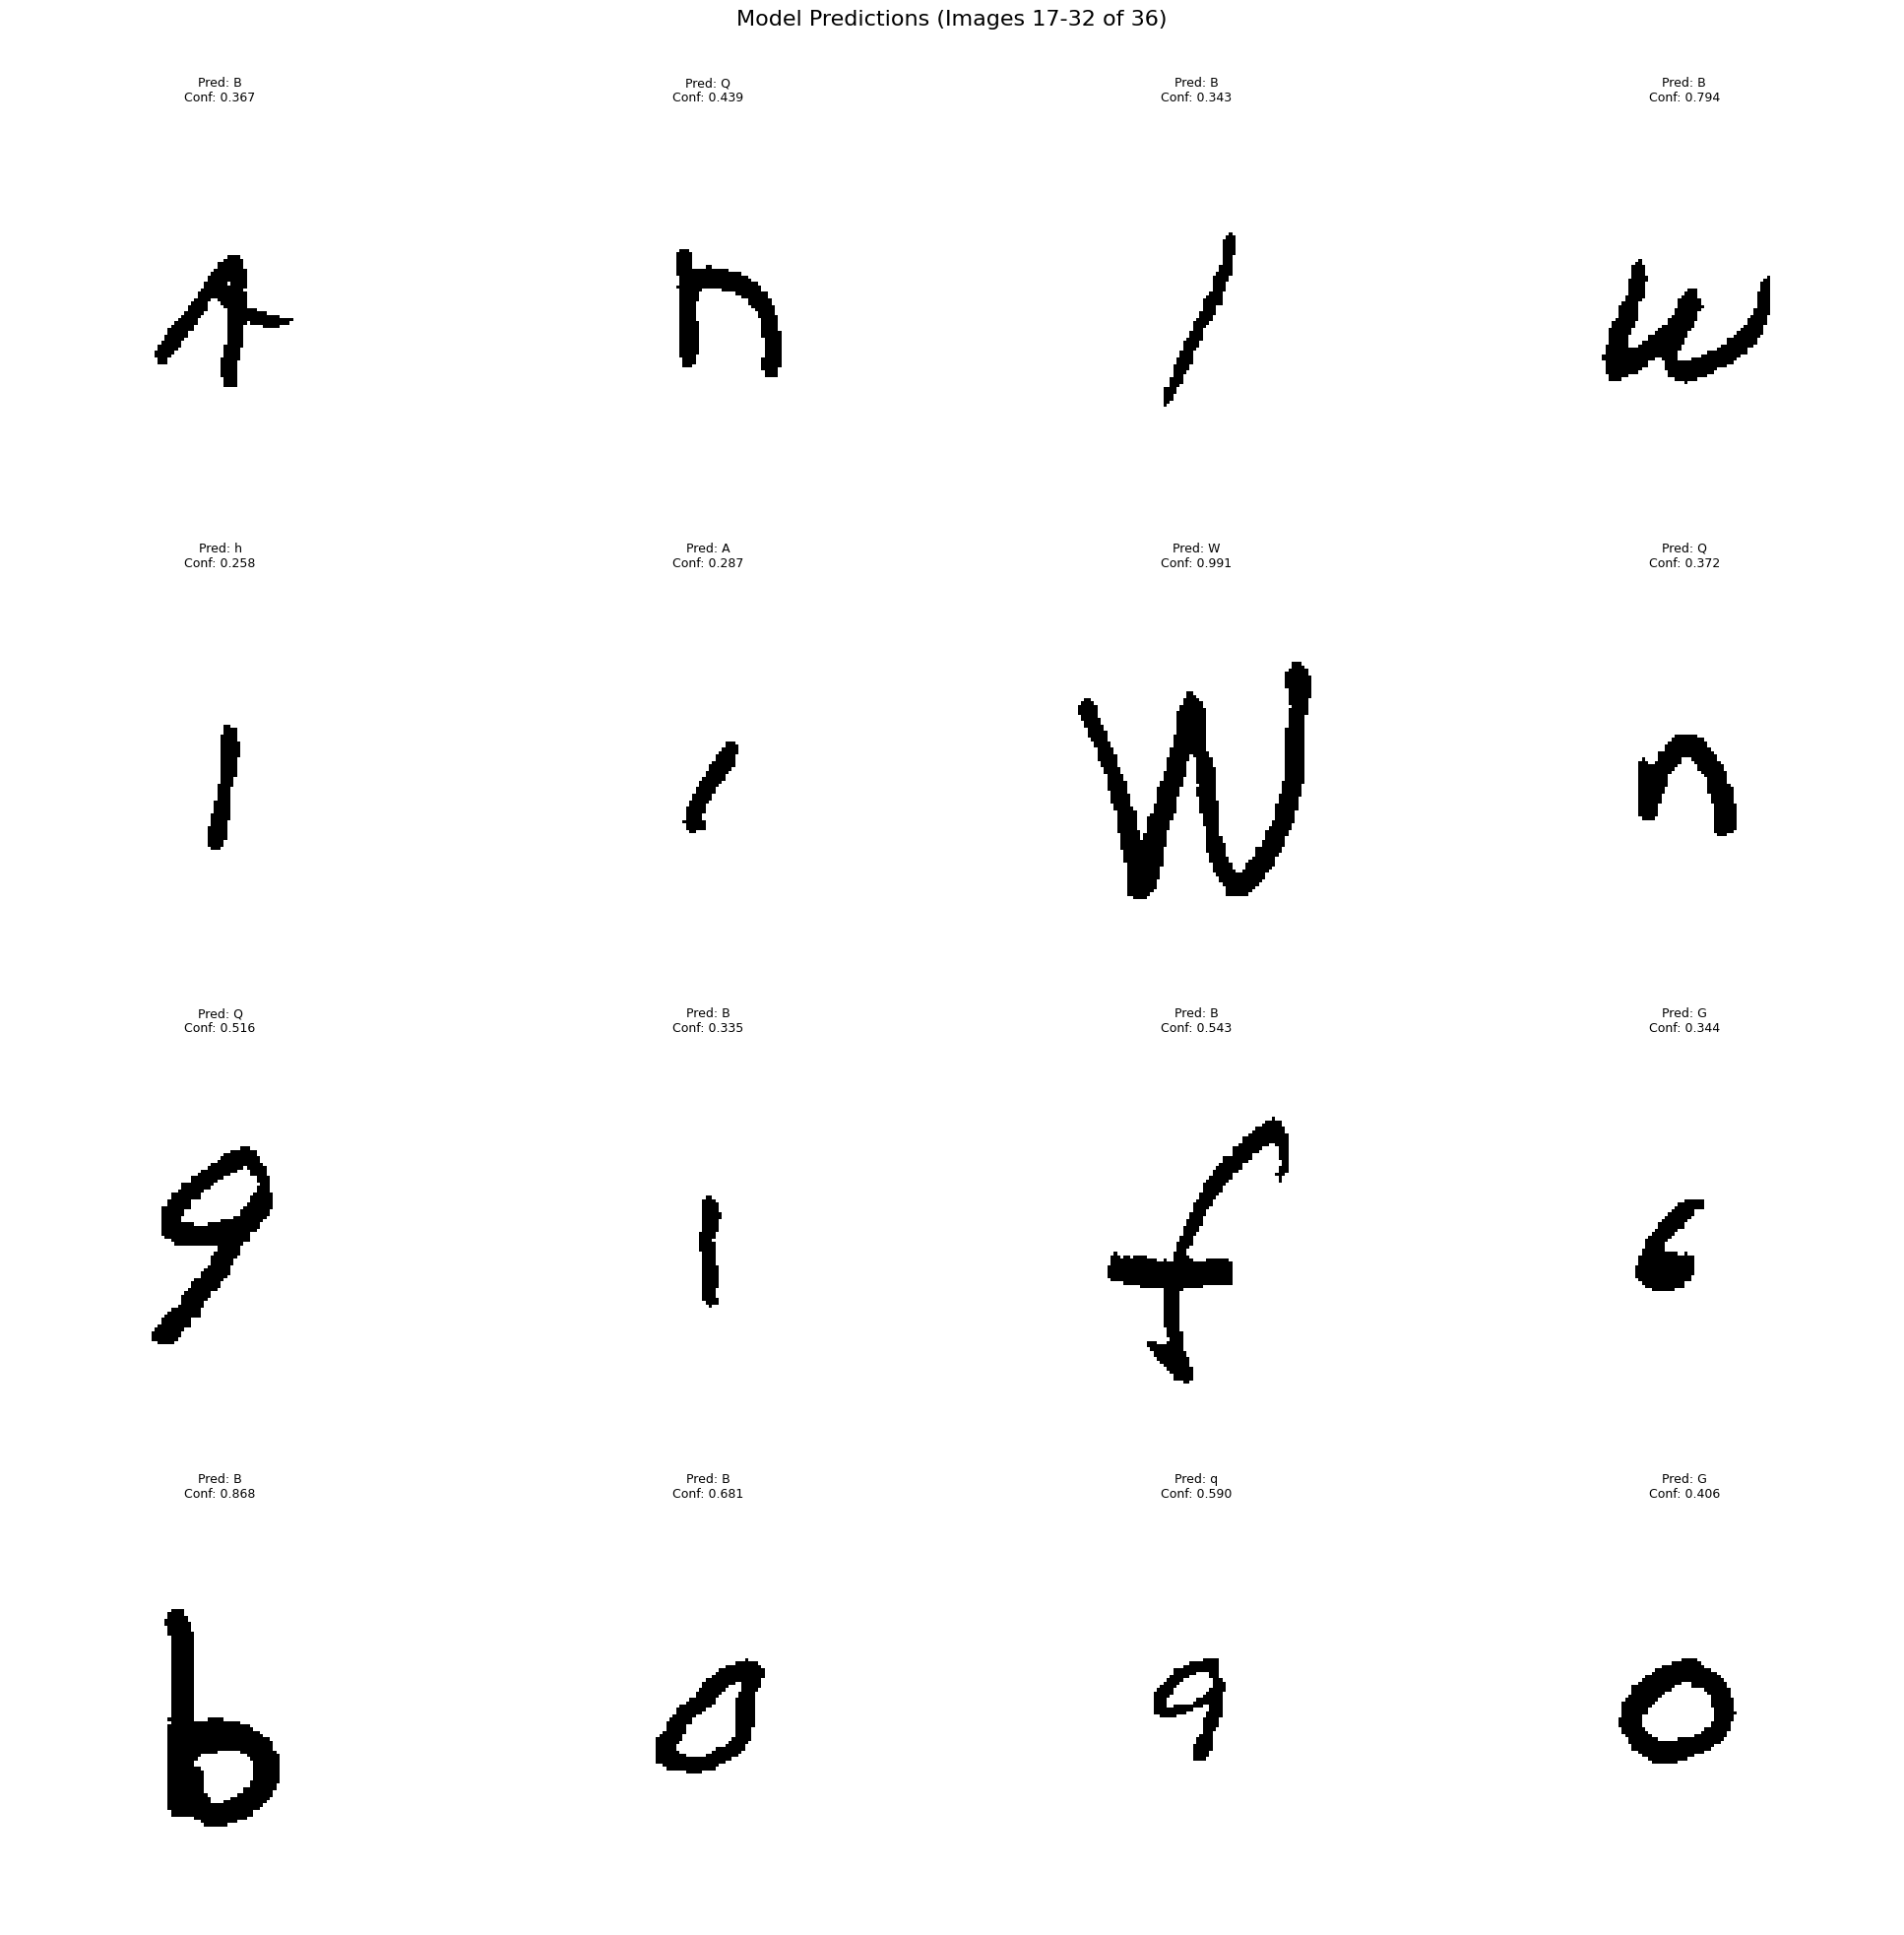

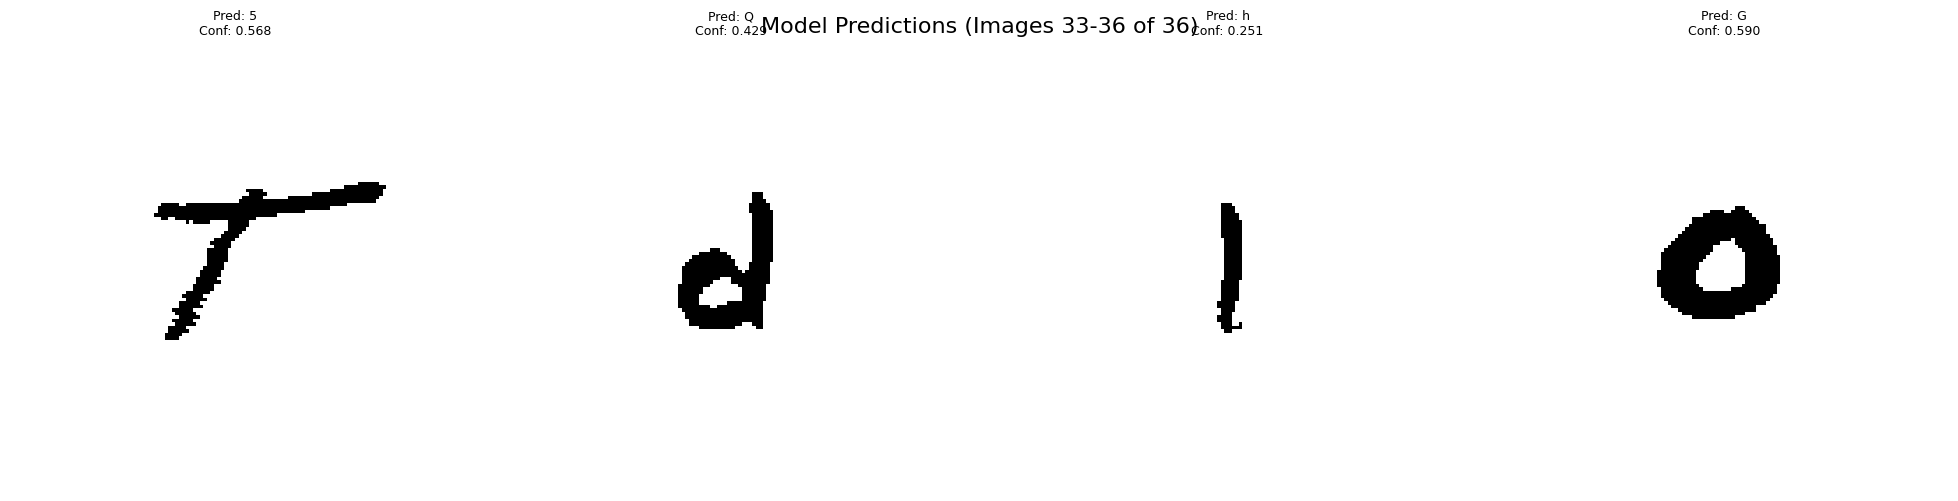

Analyzing 200 images for statistics...


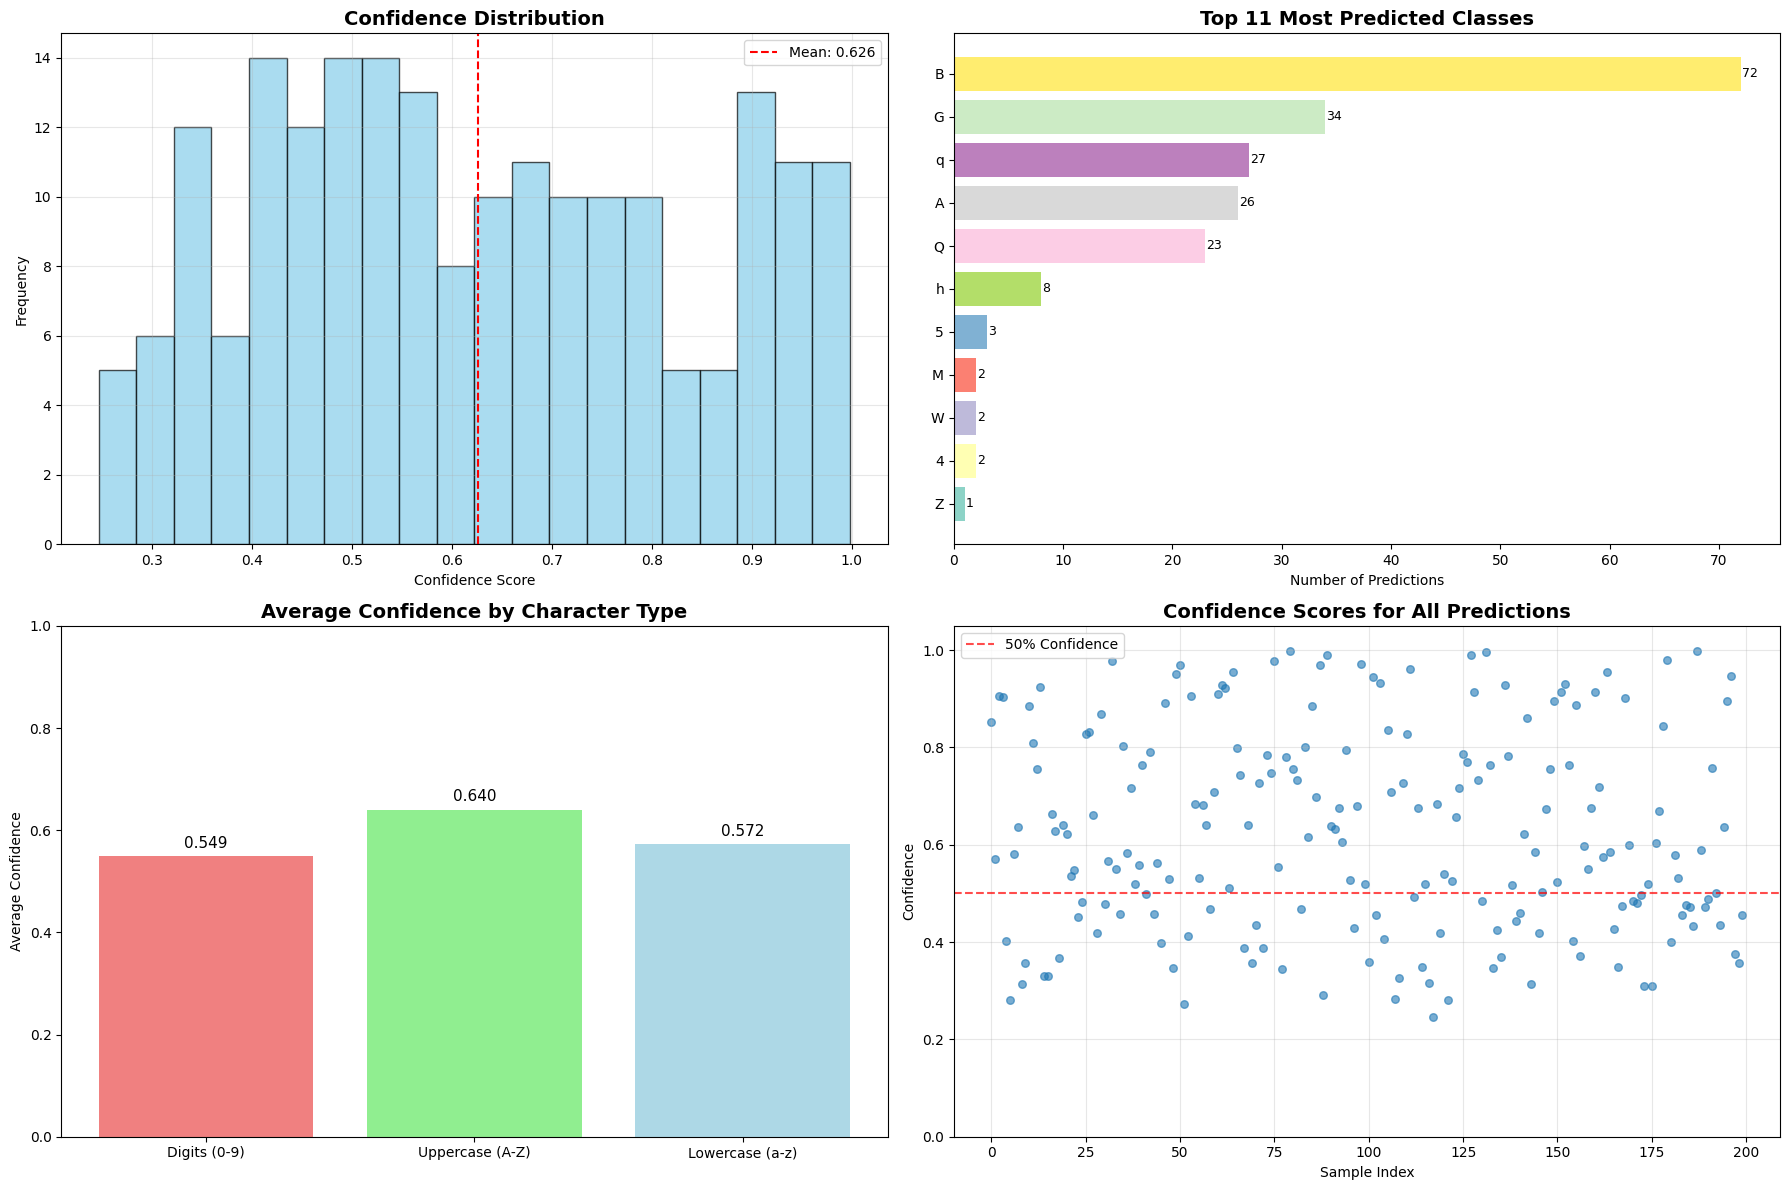


📊 Detailed Prediction Statistics (200 images):
   Average confidence: 0.6262
   Minimum confidence: 0.2470
   Maximum confidence: 0.9981
   Confidence std dev: 0.2071
   Predictions with confidence > 0.9: 31
   Predictions with confidence < 0.1: 0
   Most frequent prediction: B


In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def load_model(model_path):
    """Load the trained model"""
    try:
        model = keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def load_and_preprocess_image(image_path, img_size=(128, 128)):
    """Load and preprocess a single image"""
    try:
        # Load image in grayscale
        img = Image.open(image_path).convert('L')
        # Resize to match model's expected input
        img = img.resize(img_size)
        # Convert to numpy array
        img_array = np.array(img)
        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0
        # Add batch and channel dimensions
        img_array = np.expand_dims(img_array, axis=-1)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def predict_on_image(model, image_path, class_names):
    """Make prediction on a single image"""
    # Preprocess the image
    processed_image = load_and_preprocess_image(image_path)
    if processed_image is None:
        return None, None
    
    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    return predicted_class, confidence

def test_on_directory(model, test_dir, class_names, num_samples=36):
    """Test the model on a directory of images"""
    # Get all image paths
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
    image_paths = []
    
    for root, _, files in os.walk(test_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))
    
    if not image_paths:
        print(f"No images found in {test_dir}")
        return
    
    print(f"Found {len(image_paths)} images in the directory")
    
    # Select random samples
    if len(image_paths) > num_samples:
        selected_paths = np.random.choice(image_paths, num_samples, replace=False)
    else:
        selected_paths = image_paths
        num_samples = len(image_paths)
    
    # Create multiple figures if we have many images
    images_per_figure = 16
    num_figures = (num_samples + images_per_figure - 1) // images_per_figure
    
    for fig_idx in range(num_figures):
        start_idx = fig_idx * images_per_figure
        end_idx = min((fig_idx + 1) * images_per_figure, num_samples)
        current_paths = selected_paths[start_idx:end_idx]
        
        # Calculate grid dimensions
        num_cols = 4
        num_rows = (len(current_paths) + num_cols - 1) // num_cols
        
        plt.figure(figsize=(20, 5 * num_rows))
        plt.suptitle(f'Model Predictions (Images {start_idx + 1}-{end_idx} of {num_samples})', fontsize=16, y=0.98)
        
        # Process each image
        for i, image_path in enumerate(current_paths):
            # Make prediction
            predicted_class, confidence = predict_on_image(model, image_path, class_names)
            if predicted_class is None:
                continue
            
            # Get the predicted label
            if predicted_class < len(class_names):
                predicted_label = class_names[predicted_class]
            else:
                predicted_label = f"Unknown({predicted_class})"
            
            # Try to get actual class from folder name
            folder_name = os.path.basename(os.path.dirname(image_path))
            actual_label = "Unknown"
            title_color = 'black'
            
            # Check if folder name corresponds to a known class
            if folder_name in class_names:
                actual_label = folder_name
                title_color = 'green' if predicted_label == actual_label else 'red'
            elif folder_name.isdigit() and int(folder_name) < len(class_names):
                actual_label = class_names[int(folder_name)]
                title_color = 'green' if predicted_label == actual_label else 'red'
            
            # Load and preprocess image for display
            img = Image.open(image_path).convert('L')
            img = img.resize((128, 128))
            img_array = np.array(img)
            
            # Plot the image
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(img_array, cmap='gray')
            
            # Set title with appropriate color
            if actual_label != "Unknown":
                plt.title(f'True: {actual_label}\nPred: {predicted_label}\nConf: {confidence:.3f}', 
                         color=title_color, fontsize=9, pad=5)
            else:
                plt.title(f'Pred: {predicted_label}\nConf: {confidence:.3f}', 
                         color='black', fontsize=9, pad=5)
            
            plt.axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()

def show_detailed_statistics(model, test_dir, class_names, num_samples=100):
    """Show detailed statistics about predictions"""
    # Get all image paths
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
    image_paths = []
    
    for root, _, files in os.walk(test_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))
    
    if not image_paths:
        print(f"No images found in {test_dir}")
        return
    
    # Select samples for statistics
    if len(image_paths) > num_samples:
        selected_paths = np.random.choice(image_paths, num_samples, replace=False)
    else:
        selected_paths = image_paths
    
    predictions = []
    confidences = []
    actual_labels = []
    predicted_labels = []
    
    print(f"Analyzing {len(selected_paths)} images for statistics...")
    
    for image_path in selected_paths:
        predicted_class, confidence = predict_on_image(model, image_path, class_names)
        if predicted_class is not None:
            predictions.append(predicted_class)
            confidences.append(confidence)
            
            # Get predicted label
            if predicted_class < len(class_names):
                predicted_label = class_names[predicted_class]
            else:
                predicted_label = f"Class_{predicted_class}"
            predicted_labels.append(predicted_label)
            
            # Get actual label from folder name
            folder_name = os.path.basename(os.path.dirname(image_path))
            if folder_name in class_names:
                actual_labels.append(folder_name)
            elif folder_name.isdigit() and int(folder_name) < len(class_names):
                actual_labels.append(class_names[int(folder_name)])
            else:
                actual_labels.append("Unknown")
    
    # Create plots
    plt.figure(figsize=(18, 12))
    
    # 1. Confidence distribution
    plt.subplot(2, 2, 1)
    plt.hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(confidences), color='red', linestyle='--', label=f'Mean: {np.mean(confidences):.3f}')
    plt.title('Confidence Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. Top predicted classes
    plt.subplot(2, 2, 2)
    unique, counts = np.unique(predictions, return_counts=True)
    top_n = min(15, len(unique))
    top_indices = np.argsort(counts)[-top_n:]
    
    top_class_names = []
    for idx in top_indices:
        if unique[idx] < len(class_names):
            top_class_names.append(class_names[unique[idx]])
        else:
            top_class_names.append(f'Class_{unique[idx]}')
    
    colors = plt.cm.Set3(np.linspace(0, 1, top_n))
    bars = plt.barh(range(top_n), counts[top_indices], color=colors)
    plt.yticks(range(top_n), top_class_names)
    plt.title(f'Top {top_n} Most Predicted Classes', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Predictions')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', ha='left', va='center', fontsize=9)
    
    # 3. Confidence by class type
    plt.subplot(2, 2, 3)
    digit_confidences = []
    upper_confidences = []
    lower_confidences = []
    
    for i, pred in enumerate(predictions):
        if pred < 10:  # Digits 0-9
            digit_confidences.append(confidences[i])
        elif pred < 36:  # Uppercase A-Z
            upper_confidences.append(confidences[i])
        else:  # Lowercase a-z
            lower_confidences.append(confidences[i])
    
    categories = ['Digits (0-9)', 'Uppercase (A-Z)', 'Lowercase (a-z)']
    confidence_means = [
        np.mean(digit_confidences) if digit_confidences else 0,
        np.mean(upper_confidences) if upper_confidences else 0,
        np.mean(lower_confidences) if lower_confidences else 0
    ]
    
    bars = plt.bar(categories, confidence_means, color=['lightcoral', 'lightgreen', 'lightblue'])
    plt.title('Average Confidence by Character Type', fontsize=14, fontweight='bold')
    plt.ylabel('Average Confidence')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, confidence_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=11)
    
    # 4. Prediction confidence scatter
    plt.subplot(2, 2, 4)
    plt.scatter(range(len(confidences)), confidences, alpha=0.6, s=30)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='50% Confidence')
    plt.title('Confidence Scores for All Predictions', fontsize=14, fontweight='bold')
    plt.xlabel('Sample Index')
    plt.ylabel('Confidence')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n📊 Detailed Prediction Statistics ({len(predictions)} images):")
    print(f"   Average confidence: {np.mean(confidences):.4f}")
    print(f"   Minimum confidence: {np.min(confidences):.4f}")
    print(f"   Maximum confidence: {np.max(confidences):.4f}")
    print(f"   Confidence std dev: {np.std(confidences):.4f}")
    print(f"   Predictions with confidence > 0.9: {sum(c > 0.9 for c in confidences)}")
    print(f"   Predictions with confidence < 0.1: {sum(c < 0.1 for c in confidences)}")
    
    # Show most common predictions
    if predictions:
        most_common = np.bincount(predictions).argmax()
        if most_common < len(class_names):
            most_common_name = class_names[most_common]
        else:
            most_common_name = f"Class_{most_common}"
        print(f"   Most frequent prediction: {most_common_name}")

def main():
    # Complete EMNIST class names (62 classes) - 0-9, A-Z, a-z
    emnist_class_names = [
        # Digits 0-9 (classes 0-9)
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        
        # Uppercase A-Z (classes 10-35)
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
        'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
        'U', 'V', 'W', 'X', 'Y', 'Z',
        
        # Lowercase a-z (classes 36-61)
        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
        'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
        'u', 'v', 'w', 'x', 'y', 'z'
    ]
    
    print("📋 Class Labels Overview:")
    print(f"   Digits (0-9): Classes 0-9")
    print(f"   Uppercase (A-Z): Classes 10-35")
    print(f"   Lowercase (a-z): Classes 36-61")
    print(f"   Total classes: {len(emnist_class_names)}")
    
    # Hardcode your paths here
    model_path = "p_to_p_3.keras"  # Your model file
    test_dir = "/home/mudda/by_merge"  # Your test directory
    
    # Load the model
    model = load_model(model_path)
    if model is None:
        return
    
    # Print model summary
    print("\n" + "="*60)
    model.summary()
    print("="*60)
    
    # Test on individual images if directory is provided and exists
    if test_dir and os.path.exists(test_dir):
        print(f"\n🔍 Testing on images in {test_dir}...")
        
        # Show 36 images (more than before)
        test_on_directory(model, test_dir, emnist_class_names, num_samples=36)
        
        # Show detailed prediction statistics
        show_detailed_statistics(model, test_dir, emnist_class_names, num_samples=200)
        
    else:
        print(f"❌ Test directory {test_dir} not found or not specified")

if __name__ == "__main__":
    main()